In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import itertools

In [3]:
def ingest_data(path):
    data = pd.read_csv(path)
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    return data

In [4]:
def clean_data(data):
    lem=WordNetLemmatizer()
    stops= stopwords.words('english')
    data['corpus']=data['corpus'].apply(lambda x: " ".join([lem.lemmatize(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stops]).lower())
    data= data['corpus'].apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))
    return data

In [5]:
def visualization(data):
    # Generate a word cloud image
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(
        str(data))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

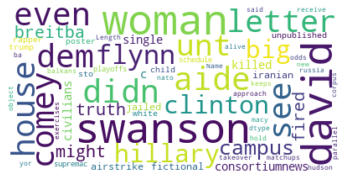

accuracy:   0.912
Confusion matrix, without normalization


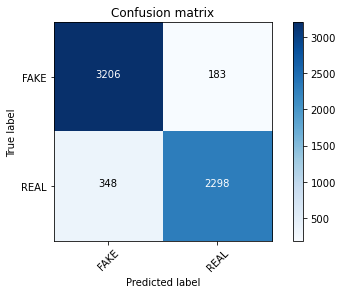

In [7]:
if __name__ == "__main__":
    ingested_data = ingest_data('Data/fake-news/train.csv')
    X=ingested_data.drop(['id', 'label'], axis=1)
    Y=ingested_data['label']
    ID=ingested_data['id']
    X['corpus'] = X.agg(' '.join, axis=1)
    cleaned_data = clean_data(X)
    visualization(cleaned_data)
    cv = CountVectorizer(max_features=5000, ngram_range=(1,3))
    X=cv.fit_transform(cleaned_data).toarray()
    ##Train Test Split
    train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size=0.33, random_state=0)
    classifier=MultinomialNB()
    classifier.fit(train_x, train_y)
    pred = classifier.predict(valid_x)
    score = metrics.accuracy_score(valid_y, pred)
    print("accuracy:   %0.3f" % score)
    cm = metrics.confusion_matrix(valid_y, pred)
    plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [8]:
cv.get_feature_names()[:20]

['aaron',
 'abandon',
 'abandoned',
 'abc',
 'abe',
 'abedin',
 'ability',
 'able',
 'abortion',
 'about',
 'abroad',
 'absence',
 'absolute',
 'absolutely',
 'abu',
 'abuse',
 'academic',
 'academy',
 'accept',
 'acceptable']

In [9]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [10]:
count_df = pd.DataFrame(train_x, columns=cv.get_feature_names())
count_df.head()

,aaron,abandon,abandoned,abc,abe,abedin,ability,able,abortion,about,...,young,young people,younger,your,youth,youtube,zero,zika,zionist,zone
0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Passive Aggresive Classifier Algorithm

In [11]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier()

accuracy:   0.963
Confusion matrix, without normalization


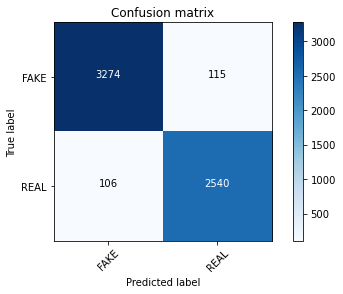

In [12]:
linear_clf.fit(train_x, train_y)
pred = linear_clf.predict(valid_x)
score = metrics.accuracy_score(valid_y, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(valid_y, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Mulinomial Classification with Hyperparameter

In [13]:
classifier=MultinomialNB(alpha=0.1)
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(train_x,train_y)
    y_pred=sub_classifier.predict(valid_x)
    score = metrics.accuracy_score(valid_y, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

C:\Users\rajhi\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.0, Score : 0.9138359569179785
Alpha: 0.1, Score : 0.9125103562551782
Alpha: 0.2, Score : 0.9123446561723281
Alpha: 0.30000000000000004, Score : 0.9121789560894781
Alpha: 0.4, Score : 0.9121789560894781
Alpha: 0.5, Score : 0.9121789560894781
Alpha: 0.6000000000000001, Score : 0.912013256006628
Alpha: 0.7000000000000001, Score : 0.912013256006628
Alpha: 0.8, Score : 0.912013256006628
Alpha: 0.9, Score : 0.912013256006628


In [14]:
## Get Features names
feature_names = cv.get_feature_names()
### Most real
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[:20]

[(-4.261194942117495, 'the'),
 (-4.970218957065564, 'trump'),
 (-5.068718683142141, 'clinton'),
 (-5.204840961687019, 'people'),
 (-5.2156821276061525, 'one'),
 (-5.360294961567886, 'would'),
 (-5.410099928074496, 'hillary'),
 (-5.60279167966574, 'year'),
 (-5.638905115455145, 'state'),
 (-5.643034793015277, 'time'),
 (-5.653755924925862, 'said'),
 (-5.66768801374436, 'like'),
 (-5.684633667985111, 'this'),
 (-5.686959289060201, 'new'),
 (-5.752952409166413, 'election'),
 (-5.768348620842929, 'world'),
 (-5.776500249200229, 'also'),
 (-5.854197842649949, 'even'),
 (-5.85892700868869, 'war'),
 (-5.8746537332673086, 'government')]

## TF-IDF Features

accuracy:   0.906
Confusion matrix, without normalization


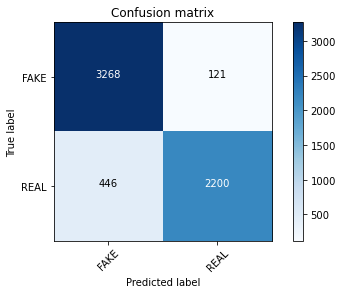

In [16]:
tf_idf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X=tf_idf.fit_transform(cleaned_data).toarray()
##Train Test Split
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size=0.33, random_state=0)
classifier=MultinomialNB()
classifier.fit(train_x, train_y)
pred = classifier.predict(valid_x)
score = metrics.accuracy_score(valid_y, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(valid_y, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.964
Confusion matrix, without normalization


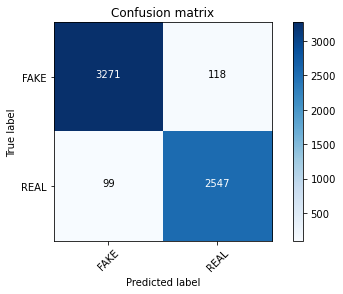

In [17]:
linear_clf = PassiveAggressiveClassifier()
linear_clf.fit(train_x, train_y)
pred = linear_clf.predict(valid_x)
score = metrics.accuracy_score(valid_y, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(valid_y, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Hashing Vectorizer

accuracy:   0.929
Confusion matrix, without normalization


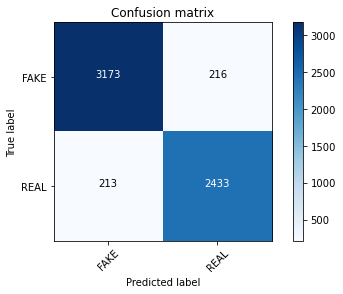

In [22]:
hv = HashingVectorizer(n_features=5000, ngram_range=(1,3))
X=hv.fit_transform(cleaned_data).toarray()
##Train Test Split
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size=0.33, random_state=0)
linear_clf = PassiveAggressiveClassifier()
linear_clf.fit(train_x, train_y)
pred = linear_clf.predict(valid_x)
score = metrics.accuracy_score(valid_y, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(valid_y, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])